In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau ,LearningRateScheduler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l2

split train and test . 60-40 . use it for 60 (60- 40 to train and test )
and remainng 40 to test

In [3]:
# Load and preprocess data
data = pd.read_csv('parks_busyness_weather.csv')




C:\Users\adi17\AppData\Local\Temp\ipykernel_30340\1771954202.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('parks_busyness_weather.csv')


In [4]:


#encode categorical features as numeri
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[['day_of_week', 'weekend', 'season', 'isHoliday?']])
encoded_feature_names = encoder.get_feature_names_out(['day_of_week', 'weekend', 'season', 'isHoliday?'])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)



In [5]:
encoded_df

,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weekend_0,weekend_1,season_1,season_2,season_3,season_4,isHoliday?_0,isHoliday?_1
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336360,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336361,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336363,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [6]:
# Concatenate encoded features with the rest of the data
numerical_data = data[['month', 'day', 'hour', 'rain_1h', 'rain_3h']]
all_features = pd.concat([numerical_data.reset_index(drop=True), encoded_df], axis=1)

In [7]:
all_features

,month,day,hour,rain_1h,rain_3h,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weekend_0,weekend_1,season_1,season_2,season_3,season_4,isHoliday?_0,isHoliday?_1
0,1,1,11,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,1,17,0.38,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1,1,19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1,10,12,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,10,13,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336360,9,9,18,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336361,9,9,19,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336362,9,9,20,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
336363,9,9,8,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
# Normalize features
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)


In [9]:
# Prepare targets
target = data['park_busyness'].values

In [10]:
# Function to create sequences
def create_sequences(input_data, target_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        y.append(target_data[i + time_steps])
    return np.array(X), np.array(y)

In [11]:
# Define time_steps (lookback period)
time_steps = 10

In [12]:
# Generate sequences
X, y = create_sequences(all_features_scaled, target, time_steps)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(20, activation='relu'),
    Dense(1)
])

c:\Users\adi17\anaconda3\envs\comp47350py311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# COMPILE THE MODEL
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:


def create_model(learning_rate=0.01):
    model = Sequential([...])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Define the grid search parameters
param_grid = {'learning_rate': [0.003, 0.001, 0.0003, 0.0001]}

# Search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [17]:
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, 
          callbacks=[early_stopping, reduce_lr], verbose=1) 
#check it for verbose=2
#check for validation 
#try 500 epochs 
#increase layers 

Epoch 1/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 5.9575 - val_loss: 6.4724 - learning_rate: 0.0010
Epoch 2/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 6.0199 - val_loss: 6.4726 - learning_rate: 0.0010
Epoch 3/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 5.8712 - val_loss: 6.4717 - learning_rate: 0.0010
Epoch 4/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 5.7692 - val_loss: 6.4688 - learning_rate: 0.0010
Epoch 5/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 6.2418 - val_loss: 6.4695 - learning_rate: 0.0010
Epoch 6/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - loss: 5.8132 - val_loss: 6.4716 - learning_rate: 0.0010
Epoch 7/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 6.0407 - val_loss: 6.4678 - learning_rate: 0.0010
Epoch 8/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - loss: 5.8803 - val_loss: 6.4632 - learning_rate: 0.0010
Epoch 9/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - loss: 6.1971 - val_loss: 

In [24]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

Test Loss: 5.135534763336182


First try
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Training stopped at 10 epochs, which indicates that the early stopping callback was triggered. Since validation loss has stopped improving. Here’s what happened during the training process:
<br>
* **Loss Values**:  Lower values are better. The fluctuation and slight increase in loss values suggest the model might be struggling to find an optimal fit to the data.
* **Early Stopping Behavior**: Since the validation loss did not show improvement for a certain number of epochs (as defined in the `patience` parameter of your EarlyStopping callback), training was halted to prevent overfitting.

Test Loss: 5.150418281555176

After training, the model was evaluated on the test set, which was not seen by the model during training to assess its predictive performance. The test loss of 5.1504 is the average loss per sample on the test set.

### SECOND ATTEMPT

Stable or Reducing Loss: The training and validation losses are showing a small reduction over epochs. However, the decrease is not substantial, and the validation loss remains almost constant across many epochs, suggesting the model might not be learning effectively from the training data or it has reached its capacity with the current configuration.

**High and Stable Validation Loss**:: Despite training, the validation loss does not show significant improvement, which can indicate a few things:

Underfitting: The model is too simple to capture the underlying patterns in the data.

Inappropriate Model Architecture: The current LSTM configuration might not be suitable for the complexity or nature of the task.

Learning Rate: The chosen learning rate might not be optimal, although adjustments are seen, which is good practice.

**Change in Learning Rate**: The reduction in learning rate is generally used to fine-tune the learning process as training progresses, aiming to make smaller adjustments to weights to reach a more optimal set of parameters.

Handlling underfitting

In [25]:
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(50, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(20, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


Fine-Tuning Learning Rate

Adjusting the learning rate can have a significant impact on model performance.

    Use a Learning Rate Scheduler: Implement a learning rate scheduler to adjust the rate dynamically based on training progress.
    Experiment with Different Rates: Conduct experiments with different initial learning rates to find a more suitable starting point.

In [28]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, 
          callbacks=[early_stopping, reduce_lr, lr_scheduler], verbose=1)


Epoch 1/100


KeyboardInterrupt: 

Increase patience: If you believe the model could improve with more training time.

Increase patience: Useful if minor fluctuations in loss are common in your training dynamics, and you want to ensure that the learning rate is only reduced when a true plateau is reached.

Improving Generalization

If the validation loss remains high or the model does not generalize well, consider the following:

    Increase Dropout Rates: Helps in preventing the model from overfitting and can aid in generalization.
    Regularization Techniques: Implement L1 or L2 regularization in your LSTM layers to penalize overly complex models.

In [33]:

model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(50, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(20, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [34]:

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)  # Increased from 15 to 25


In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001)  # Increased from 5 to 10


In [36]:
# Fit the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=100,  # Total number of epochs to train
    batch_size=64,  # Number of samples per gradient update
    validation_split=0.2,  # Fraction of the training data to be used as validation data
    callbacks=[early_stopping, reduce_lr],  # List of callbacks to apply during training
    verbose=1  # Verbosity mode (1 = progress bar)
)


Epoch 1/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 166s 44ms/step - loss: 6.1150 - val_loss: 6.4744 - learning_rate: 0.0010
Epoch 2/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 181s 54ms/step - loss: 5.7840 - val_loss: 6.4743 - learning_rate: 0.0010
Epoch 3/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - loss: 5.7297 - val_loss: 6.4733 - learning_rate: 0.0010
Epoch 4/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - loss: 6.0364 - val_loss: 6.4732 - learning_rate: 0.0010
Epoch 5/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - loss: 6.1194 - val_loss: 6.4733 - learning_rate: 0.0010
Epoch 6/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - loss: 6.0049 - val_loss: 6.4735 - learning_rate: 0.0010
Epoch 7/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step - loss: 6.0181 - val_loss: 6.4732 - learning_rate: 0.0010
Epoch 8/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - loss: 6.3051 - val_loss: 6.4732 - learning_rate: 0.0010
Epoch 9/100
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - loss: 5.7469 - val_

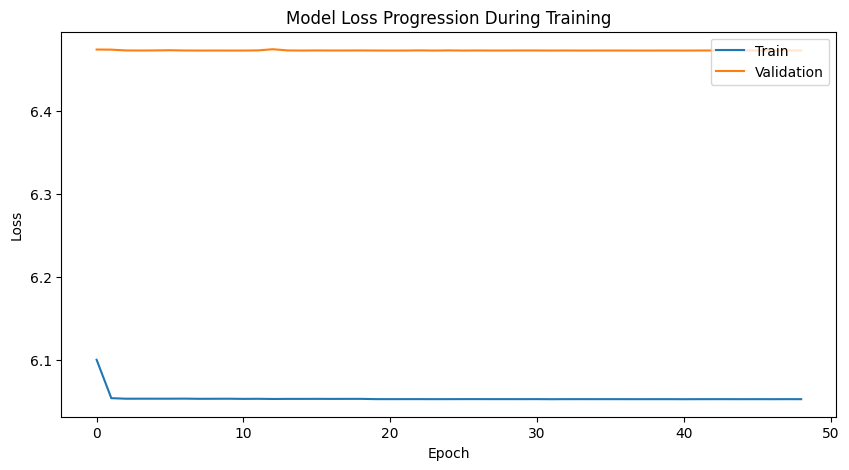

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
